#### iLQR for kinematic example with obstacle

##### Note that the collision here is only checked between the end-effector point and the obstacle, not the whole robot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from ocp import *
from costs import *
from ocp_utils import *

%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=4, suppress=True)

#### Create 2link robot 

In [2]:
dt = 0.01
T = 100
ee_id = 1

sys = TwoLinkRobot(dt = dt)
x0 = np.array([0,0,0,0])
sys.set_init_state(x0)


#set initial control output to be all zeros
us = np.zeros((T+1,sys.Du))
_ = sys.compute_matrices(x0, us[0])
xs = sys.rollout(us[:-1])

#### Plot initial trajectory

#### Set the regularization cost coefficients Q and R 

In [3]:
Q = np.eye(sys.Dx)*.1
Q[0:2,0:2] *= 0.0        #only put cost regularization on the velocity, not on the joint angles
Qf = np.eye(sys.Dx)*1
Qf[0:2,0:2] *= 0.0       #only put cost regularization on the velocity, not on the joint angles
R = np.eye(sys.Du)*.1
mu = 1e-6                #regularization coefficient

#### Set end effector reference 

In [4]:
#W and WT: cost coefficients for the end-effector reaching task

p_ref = np.array([.5, .8])
W = np.eye(2)*1
WT = np.eye(2)*100
sys.set_pref(p_ref)

#### Set obstacle

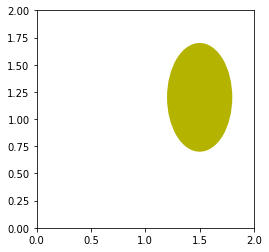

In [5]:
p_obs1 = np.array([1.5,1.2])  #obstacle position
r_obs1 = np.array([0.3, 0.5]) #radius of the ellipse
ori_obs1 = 0  #rotate the ellipse clockwise
w_obs1 = 100   #weight of the obstacle cost

#compute the covariance matrix of the ellipse
Sigma_obs1 = compute_covariance(r_obs1, ori_obs1)


#plot the ellipse
fig, ax = plt.subplots()
plot_gaussian_2D(p_obs1, Sigma_obs1, ax=ax)
ax.set_xlim(0, 2)
ax.set_ylim(0,2)
ax.set_aspect('equal')

### iLQR using cost model

#### Define the cost

In [6]:
#The costs consist of: a) state regularization (Q), b) control regularization (R),  c) End-effector reaching task (W), and d) Obstacle cost w_obs1
#Running cost is for the time 0 <= t < T, while terminal cost is for the time t = T
costs = []
for i in range(T):
    runningStateCost = CostModelQuadratic(sys, Q)
    runningControlCost = CostModelQuadratic(sys, None, R)
    runningEECost = CostModelQuadraticTranslation(sys,W,ee_id,p_ref)
    runningObstacleCost = CostModelCollisionEllipsoid(sys, p_obs1, Sigma_obs1, ee_id, w_obs1, d_thres=1.)    
    runningCost = CostModelSum(sys, [runningStateCost, runningControlCost, runningEECost, runningObstacleCost])
    costs += [runningCost]

terminalStateCost = CostModelQuadratic(sys,Qf)
terminalControlCost = CostModelQuadratic(sys, None,R)
terminalEECost = CostModelQuadraticTranslation(sys,WT,ee_id,p_ref)
terminalObstacleCost = CostModelCollisionEllipsoid(sys, p_obs1, Sigma_obs1, ee_id, w_obs1, d_thres = 1.)
terminalCost = CostModelSum(sys, [terminalStateCost, terminalControlCost, terminalEECost,terminalObstacleCost])

costs += [terminalCost]

#### Construct ILQR

In [7]:
ilqr_cost = ILQR(sys, mu)
ilqr_cost.set_init_state(x0)
ilqr_cost.set_timestep(T)
ilqr_cost.set_cost(costs)
ilqr_cost.set_state(xs, us)

#### Solve and Plot

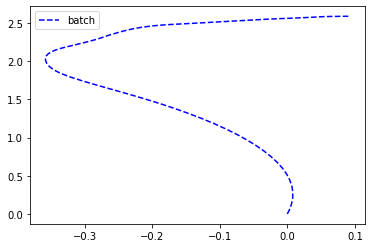

In [8]:
n_iter = 10
ilqr_cost.solve(n_iter, method='batch')
xs_batch, us_batch = ilqr_cost.xs, ilqr_cost.us

clear_output()
plt.plot(xs_batch[:,0], xs_batch[:,1], 'b--', label='batch')
plt.legend()
plt.show()

#### Play traj

In [9]:
def plot_traj(xs, dt = 0.1):
    for x in xs:
        clear_output(wait=True)
        fig, ax = plt.subplots()
        ax.plot(sys.p_ref[0], sys.p_ref[1], '*')
        plot_gaussian_2D(p_obs1, Sigma_obs1, ax=ax)
        ax.set_aspect('equal')
        sys.plot(x)
        plt.show()
        time.sleep(sys.dt)

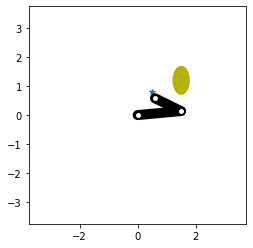

In [10]:
plot_traj(ilqr_cost.xs)